In [1]:
import grafiti as gf
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import squidpy as sq
from sklearn import metrics
import umap as umap_ext
import pandas as pd
import pickle
import seaborn as sns
import torch

import warnings
warnings.filterwarnings('ignore')

datadir = "/data1/shahs3/users/mezallj1/data/osmfish"
figdir = "/data1/shahs3/users/mezallj1/figures/osmfish"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def umap(adata, encoding_key="X_grafiti",n_neighbors=20,max_iter=100, min_dist=0.5, metric="euclidean", scanpy=False, neighbors_key="grafiti_neighbors", embd_name="X_umap"):
    if not scanpy:
        ldm = umap_ext.UMAP(n_epochs=max_iter,
                        n_neighbors=n_neighbors,
                        min_dist=min_dist,
                        metric=metric)
        embd = ldm.fit_transform(adata.obsm[encoding_key])
        adata.obsm[embd_name] = embd
    else:
        sc.tl.umap(adata,neighbors_key=neighbors_key)

# 10 Iterations

In [21]:
def read_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

In [22]:
def plot_spatial(datadir, iteration):
    adata_graphst = sc.read_h5ad(f'{datadir}/graphst/osmfish_graphst_{iteration}.h5ad')
    adata_stagate = sc.read_h5ad(f'{datadir}/stagate/osmfish_stagate_{iteration}.h5ad')
    adata_grafiti = sc.read_h5ad(f'{datadir}/grafiti/osmfish_grafiti_{iteration}.h5ad')

    adata_stagate.obs['mclust'] = pd.Series(adata_stagate.obs['mclust']).astype('category')
    
    fig, axes = plt.subplots(1, 4, figsize=(24, 4))
    sc.pl.embedding(adata_graphst, basis='spatial', title = 'Ground Truth', color='Region', ax=axes[0], s=50, show=False)
    sc.pl.embedding(adata_graphst, basis='spatial', title = 'GraphST: %.3f'%(graphst[iteration]), color ='mclust', ax=axes[1], s=50, show=False)
    sc.pl.embedding(adata_stagate, basis='spatial', title = 'STAGATE: %.3f'%(stagate[iteration]), color ='mclust', ax=axes[2], s=50, show=False)
    sc.pl.embedding(adata_grafiti, basis='spatial', title = 'Grafiti: %.3f'%(grafiti[iteration]), color ='grafiti_motif', ax=axes[3], s=50, show=False)
    plt.tight_layout()
    plt.show()

In [23]:
stagate = read_pickle(f'{datadir}/stagate/ari_stagate.pkl')
graphst = read_pickle(f'{datadir}/graphst/ari_graphst.pkl')
grafiti = read_pickle(f'{datadir}/grafiti/ari_grafiti.pkl')

In [24]:
stagate

{1: 0.14926696206013118,
 2: 0.14926696206013118,
 3: 0.14926696206013118,
 4: 0.14926696206013118,
 5: 0.14926696206013118,
 6: 0.14926696206013118,
 7: 0.14926696206013118,
 8: 0.14926696206013118,
 9: 0.14926696206013118,
 10: 0.14926696206013118}

In [25]:
df = pd.DataFrame({
    'GraphST': graphst,
    'STAGATE': stagate,
    'Graffiti': grafiti
})

In [26]:
df

,GraphST,STAGATE,Graffiti
1,0.3828,0.149267,0.175999
2,0.3828,0.149267,0.182037
3,0.3828,0.149267,0.121762
4,0.3828,0.149267,0.182644
5,0.3828,0.149267,0.074645
6,0.3828,0.149267,0.038739
7,0.3828,0.149267,0.092166
8,0.3828,0.149267,0.003012
9,0.3828,0.149267,0.227072
10,0.3828,0.149267,0.119168


In [27]:
# Transpose the DataFrame to get keys as rows and dictionaries as columns
df = df.T

# Melt the DataFrame for seaborn
df_melted = df.reset_index().melt(id_vars='index', var_name='Sample', value_name='Score')
df_melted.rename(columns={'index': 'Method'}, inplace=True)

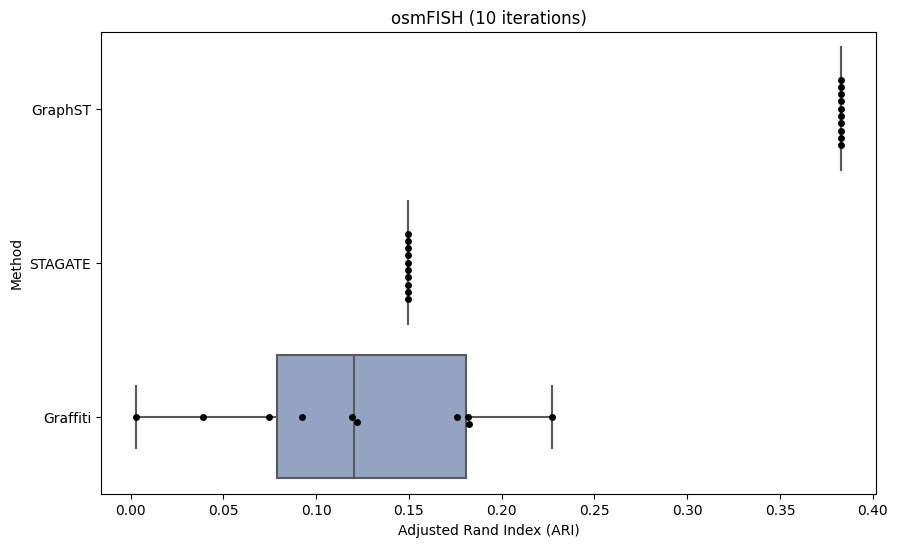

In [28]:
# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='Score', y='Method', data=df_melted, palette='Set2')
sns.swarmplot(x='Score', y='Method', data=df_melted, color='k', size=5)

# Customizing the plot
plt.xlabel('Adjusted Rand Index (ARI)')
plt.ylabel('Method')
plt.title('osmFISH (10 iterations)')
plt.show()

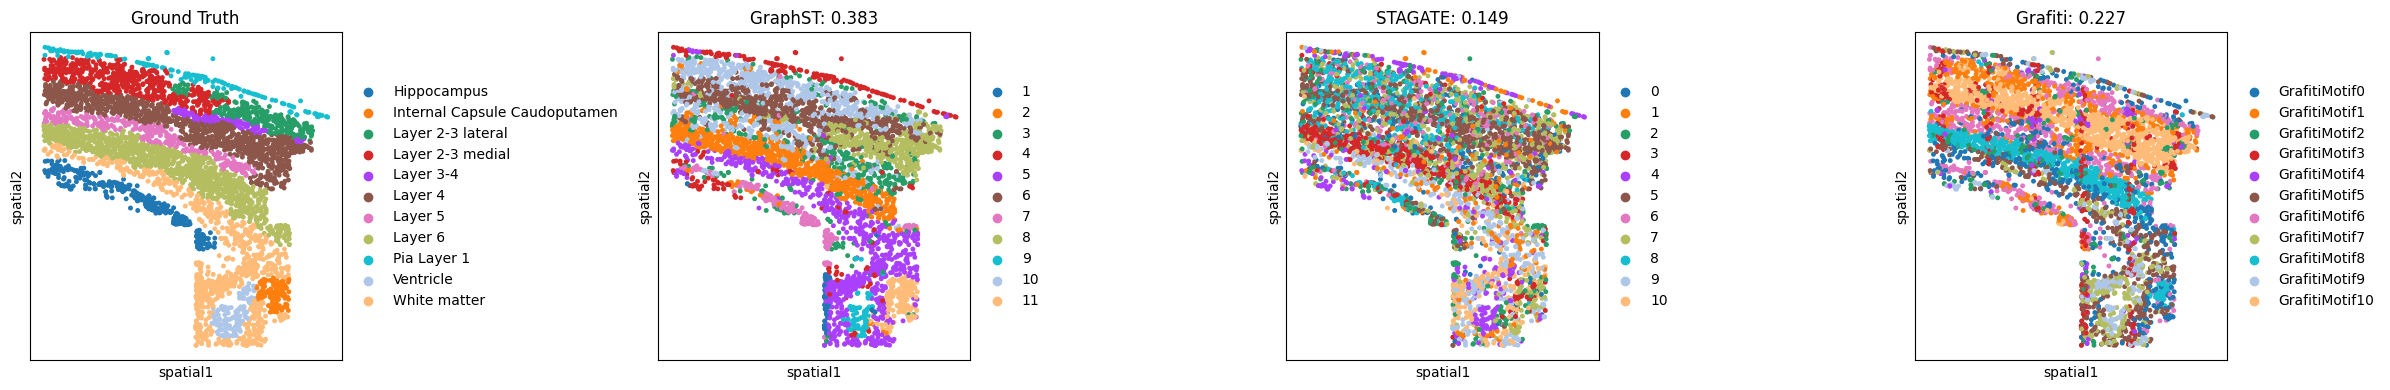

In [30]:
plot_spatial(datadir, 9)

# GRAFITI

In [129]:
adata = sc.read_h5ad(f'{datadir}/raw/osmfish_remove_excluded.h5ad')
adata

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region'
    uns: 'ClusterName_colors'
    obsm: 'spatial'

In [130]:
sq.gr.spatial_neighbors(adata,radius=50,coord_type='generic',delaunay=True) # Creates spatial_connectivities and spatial_distances in 'obsp' from spatial location (x,y) in 'obsm'

In [281]:
gae = gf.ml.GAE(adata, layers=[20,20], lr=0.01, device=device)#, exponent=2, distance_scale=10)

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!


In [282]:
gae.train(10000, update_interval=100, threshold=1e-3, patience=10)

Epoch 0 ** iteration 0 ** Loss: 133982.984375
Epoch 100 ** iteration 100 ** Loss: 121731.509140625
Epoch 200 ** iteration 200 ** Loss: 106698.244453125
Epoch 300 ** iteration 300 ** Loss: 96782.6353125
Epoch 400 ** iteration 400 ** Loss: 96385.73015625
Epoch 500 ** iteration 500 ** Loss: 93912.904140625
Epoch 600 ** iteration 600 ** Loss: 75700.686484375
Epoch 700 ** iteration 700 ** Loss: 73308.3175
Epoch 800 ** iteration 800 ** Loss: 72736.3340625
Epoch 900 ** iteration 900 ** Loss: 72612.432734375
Epoch 1000 ** iteration 1000 ** Loss: 72587.70140625
Epoch 1100 ** iteration 1100 ** Loss: 72266.4203125
Epoch 1200 ** iteration 1200 ** Loss: 71902.1984375
Epoch 1300 ** iteration 1300 ** Loss: 71773.979453125
Epoch 1400 ** iteration 1400 ** Loss: 71712.79
Epoch 1500 ** iteration 1500 ** Loss: 71666.083828125
Epoch 1600 ** iteration 1600 ** Loss: 71616.807890625
Epoch 1700 ** iteration 1700 ** Loss: 71562.019921875
Epoch 1800 ** iteration 1800 ** Loss: 71528.474609375
Epoch 1900 ** iterat

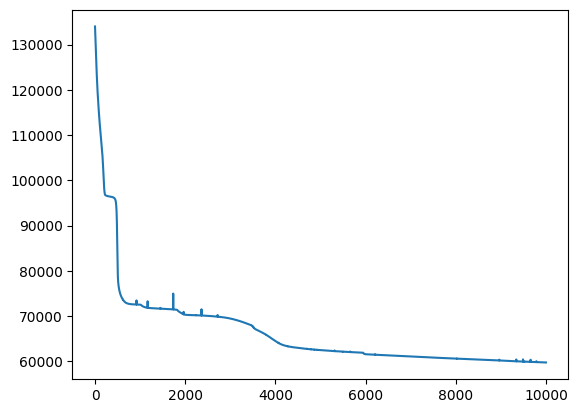

In [283]:
gae.plot()

In [284]:
gae.load_embedding(adata, encoding_key="X_grafiti") # Load features into the z latent space

In [285]:
gf.tl.umap(adata) # Embed grafiti latent space into umap latent space (2 dimensions)

In [286]:
gf.tl.find_motifs_gmm(adata,k=11)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged: True


GaussianMixture(covariance_type='spherical', n_components=11, random_state=0,
                verbose=True)

# Leiden

In [287]:
#adata_leiden = adata.copy()

In [288]:
#n_clusters=11    #according own dataset

In [289]:
#sc.tl.pca(adata_leiden, n_comps=50, svd_solver='arpack')
#sc.pp.neighbors(adata_leiden, n_neighbors=100, n_pcs=50) # 20
#eval_resolution = 2
#sc.tl.leiden(adata_leiden, key_added="leiden", resolution=eval_resolution)

In [290]:
#sc.pl.embedding(adata_leiden, basis='spatial', color ='leiden', s=20, add_outline=True)

# GraphST

In [291]:
adata_graphst = sc.read_h5ad(f'{datadir}/graphst/osmfish_graphst.h5ad')

In [292]:
adata.obs['graphst'] = adata_graphst.obs['domain']

In [293]:
adata_graphst

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region', 'mclust', 'domain'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'ClusterName_colors', 'Region_colors', 'domain_colors', 'hvg', 'log1p'
    obsm: 'adj', 'distance_matrix', 'emb', 'emb_pca', 'feat', 'feat_a', 'graph_neigh', 'label_CSL', 'spatial'

In [294]:
umap(adata_graphst, encoding_key="emb")

# STAGATE

In [295]:
adata_stagate = sc.read_h5ad(f'{datadir}/stagate/osmfish_stagate.h5ad')

In [296]:
adata_stagate.obs['mclust'] = pd.Series(adata_stagate.obs['mclust']).astype('category')

In [297]:
adata.obs['stagate'] = adata_stagate.obs['mclust']

In [298]:
adata

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region', 'grafiti_motif', 'GrafitiMotif0_proba', 'GrafitiMotif1_proba', 'GrafitiMotif10_proba', 'GrafitiMotif2_proba', 'GrafitiMotif3_proba', 'GrafitiMotif4_proba', 'GrafitiMotif5_proba', 'GrafitiMotif6_proba', 'GrafitiMotif7_proba', 'GrafitiMotif8_proba', 'GrafitiMotif9_proba', 'graphst', 'stagate'
    uns: 'ClusterName_colors', 'spatial_neighbors', 'grafiti_motif_proba', 'Region_colors', 'graphst_colors', 'stagate_colors', 'grafiti_motif_colors'
    obsm: 'spatial', 'X_grafiti', 'X_umap'
    obsp: 'spatial_connectivities', 'spatial_distances'

# Plots

In [299]:
# calculate metric ARI
graphst_ari = metrics.adjusted_rand_score(adata.obs['graphst'], adata.obs['Region'])
stagate_ari = metrics.adjusted_rand_score(adata.obs['stagate'], adata.obs['Region'])
grafiti_ari = metrics.adjusted_rand_score(adata.obs['grafiti_motif'], adata.obs['Region'])

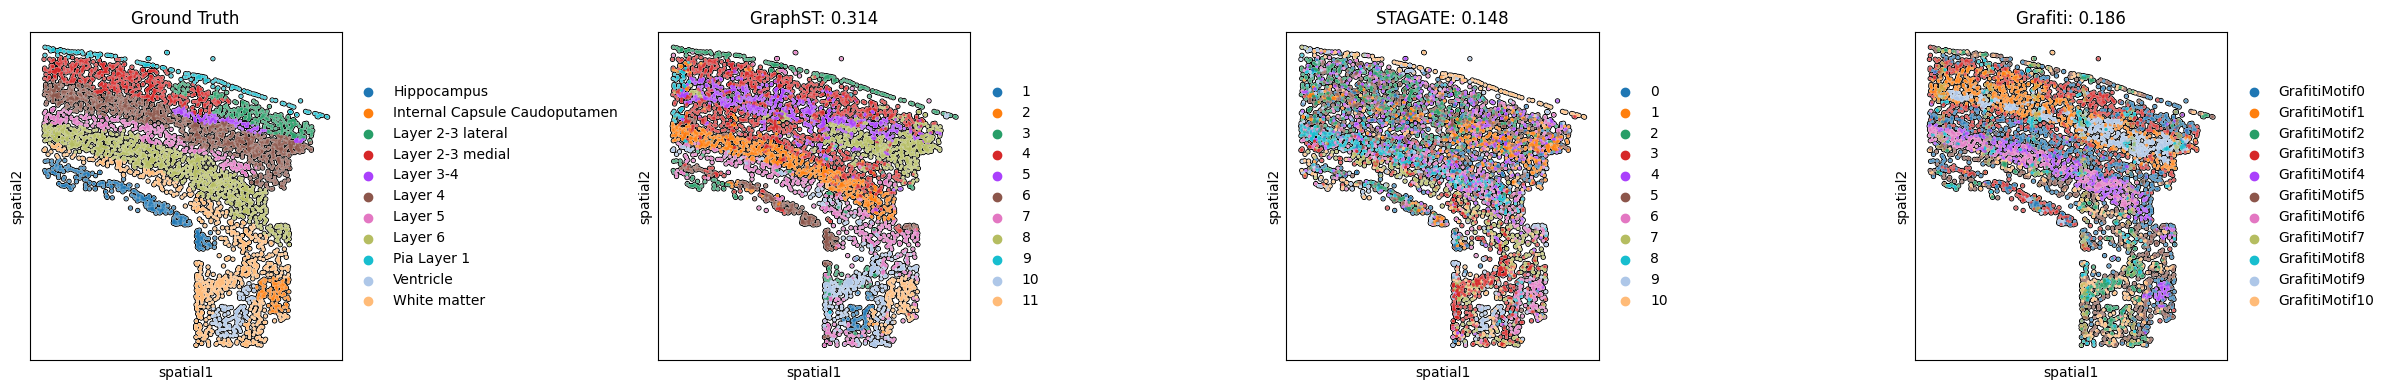

<Figure size 640x480 with 0 Axes>

In [300]:
fig, axes = plt.subplots(1, 4, figsize=(24, 4))
sc.pl.embedding(adata, basis='spatial', title = 'Ground Truth', color='Region', ax=axes[0], s=20, add_outline=True, show=False)
sc.pl.embedding(adata, basis='spatial', title = 'GraphST: %.3f'%(graphst_ari), color ='graphst', ax=axes[1], s=20, add_outline=True, show=False)
sc.pl.embedding(adata, basis='spatial', title = 'STAGATE: %.3f'%(stagate_ari), color ='stagate', ax=axes[2], s=20, add_outline=True, show=False)
sc.pl.embedding(adata, basis='spatial', title = 'Grafiti: %.3f'%(grafiti_ari), color ='grafiti_motif', ax=axes[3], s=20, add_outline=True, show=False)
plt.tight_layout()
plt.show()
plt.savefig(f'{figdir}/osmfish_spatial.png', bbox_inches="tight")

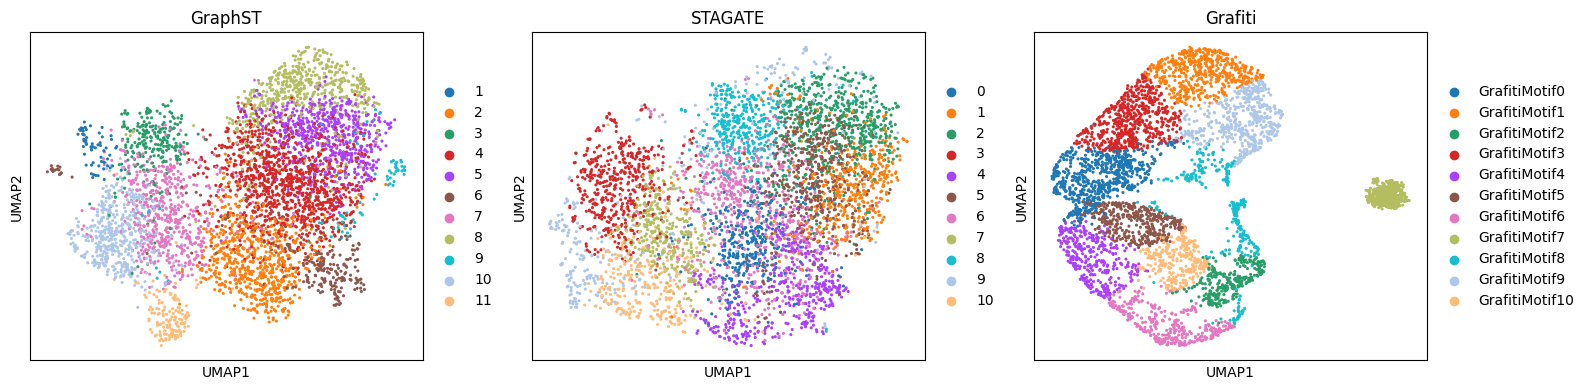

<Figure size 640x480 with 0 Axes>

In [301]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sc.pl.umap(adata_graphst,title="GraphST",color=["domain"],ax=axes[0],s=20,show=False)
sc.pl.umap(adata_stagate,title="STAGATE",color=["mclust"],ax=axes[1],s=20,show=False)
sc.pl.umap(adata,title="Grafiti",color=["grafiti_motif"],ax=axes[2],s=20,show=False)
plt.tight_layout()
plt.show()
plt.savefig(f'{figdir}/osmfish_umap.png', bbox_inches="tight")

In [259]:
adata

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region', 'grafiti_motif', 'GrafitiMotif0_proba', 'GrafitiMotif1_proba', 'GrafitiMotif10_proba', 'GrafitiMotif2_proba', 'GrafitiMotif3_proba', 'GrafitiMotif4_proba', 'GrafitiMotif5_proba', 'GrafitiMotif6_proba', 'GrafitiMotif7_proba', 'GrafitiMotif8_proba', 'GrafitiMotif9_proba', 'graphst', 'stagate'
    uns: 'ClusterName_colors', 'spatial_neighbors', 'grafiti_motif_proba', 'Region_colors', 'graphst_colors', 'stagate_colors', 'grafiti_motif_colors'
    obsm: 'spatial', 'X_grafiti', 'X_umap'
    obsp: 'spatial_connectivities', 'spatial_distances'

# Distribution Testing

In [4]:
plot_data = adata.to_df()
features = ['Gad2', 'Slc32a1', 'Crhbp', 'Cnr1', 'Vip', 'Cpne5', 'Pthlh', 'Crh',
       'Tbr1', 'Lamp5', 'Rorb', 'Syt6', 'Kcnip2', 'Aldoc', 'Gfap', 'Serpinf1',
       'Mfge8', 'Sox10', 'Plp1', 'Pdgfra', 'Bmp4', 'Itpr2', 'Tmem2', 'Ctps',
       'Anln', 'Mrc1', 'Hexb', 'Ttr', 'Foxj1', 'Vtn', 'Flt1', 'Apln', 'Acta2']

/tmp/ipykernel_3351785/3580000630.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


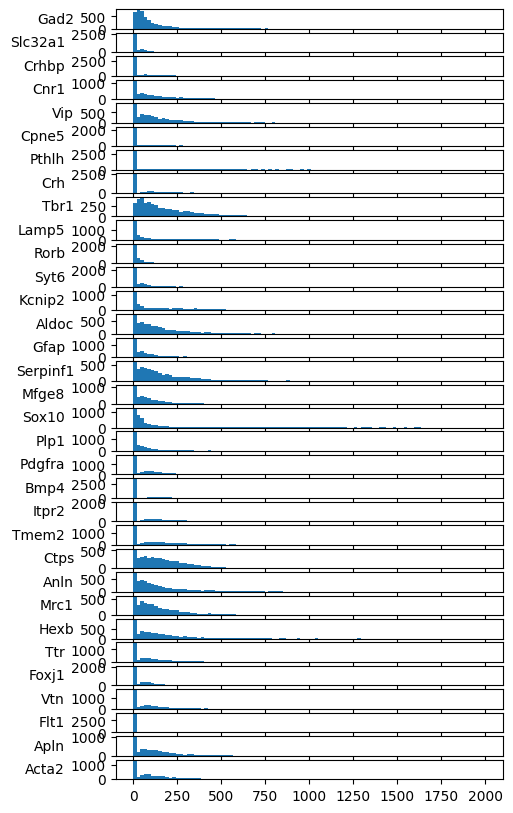

In [5]:
fig, axes = plt.subplots(nrows=len(features), figsize=(5, 10))

for f, ax in zip(features, axes):
    #ax.set_xscale('log')
    ax.hist(plot_data[f], bins=np.linspace(0,2000,100))#, bins=np.logspace(np.log10(1.0), np.log10(10000.0), 50))
    ax.set_ylabel(f, rotation=0, ha='right', va='center')

plt.tight_layout()